<a href="https://colab.research.google.com/github/pearl-yu/twitch_project/blob/main/raid_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/twitch_data

/content/drive/MyDrive/twitch_data


In [4]:
%ls

1013713136.mp4                  raid/        sentiments4
chat_df.csv                     raid_df.csv  sentiments5
chat_features_womeaningful.csv  sentiments   vid_df_wraid.csv
data_vid_df_l.csv               sentiments1  video_df_merge.csv
features_vid_df_lag.csv         sentiments2
features_vid_df_lag_raid.csv    sentiments3


In [5]:
# just want to take a look at the chats containing raid information
chat_df = pd.read_csv('chat_df.csv',lineterminator='\n',index_col=0) 
chat_df.head()

temp_table = chat_df[chat_df['messages'].str.contains('raid',na=False)]
temp_table

,video_url,timestamp,time_in_seconds,author_id,author_name,author_bio,messages
666,https://www.twitch.tv/videos/1619944979,1665355121824000,1188.124,238777489,Michael7461,NaN,"@mayraidensenpai, who said that KEKW"
3000,https://www.twitch.tv/videos/1619944979,1665357892701000,3959.001,40139265,Itzmochi808,Howzit everyone!! I am a variety streamer! 18+...,we out here raiding twitch con
5745,https://www.twitch.tv/videos/1619944979,1665363838449000,9904.749,100135110,StreamElements,Elevate your content with www.StreamElements.c...,craidfn - (1800 DPI) Apex: 1.1 / ADS 1.05 | Va...
6070,https://www.twitch.tv/videos/1619944979,1665364571655000,10637.955,635793543,GrayJune7,NaN,I'm afraid of that droplet on the top monkaW
16565,https://www.twitch.tv/videos/1610408161,1665015072860000,2107.160,447167204,rmaton89,NaN,@dalordraiden it was a joke but clout is like ...
...,...,...,...,...,...,...,...
225041,https://www.twitch.tv/videos/1591613035,1663259993856000,7586.156,424089063,alankbrr,NaN,!raid
225063,https://www.twitch.tv/videos/1591613035,1663260144079000,7736.379,142432529,iipan,NaN,!raid
225090,https://www.twitch.tv/videos/1591613035,1663260437669000,8029.969,733199350,kiboy1111,NaN,!raid
225210,https://www.twitch.tv/videos/1591613035,1663261861871000,9454.171,552536197,culprith,NaN,!raid


In [6]:
# to get the list of streamers in sample, also will later merge raid data into this
# from independent_variable_chat_exploration.ipynb output
features_vid_df_lag = pd.read_csv('features_vid_df_lag.csv',lineterminator='\n',index_col=0) 
features_vid_df_lag.columns

Index(['user_id', 'video_id', 'video_url', 'num_messages', 'message_len',
       'video_id.1', 'num_messages_per_min', 'user_id.1', 'user_name',
       'duration_min', 'created_at', 'title', 'view_count', 'broadcaster_type',
       'broadcast_description', 'broadcaster_created_at',
       'avg_messages_per_min', 'sentiment_positive_percent', 'sentiment_score',
       'video_url_lag', 'num_messages_lag', 'message_len_lag', 'video_id_lag',
       'num_messages_per_min_lag', 'user_id_lag', 'user_name_lag',
       'duration_min_lag', 'created_at_lag', 'title_lag', 'view_count_lag',
       'broadcaster_type_lag', 'broadcast_description_lag',
       'broadcaster_created_at_lag', 'avg_messages_per_min_lag',
       'sentiment_positive_percent_lag', 'sentiment_score_lag',
       'time_after_last_stream', 'time_after_last_stream_end', 'user_id_post',
       'created_at_post', 'time_till_next_stream',
       'time_till_last_stream_afterend'],
      dtype='object')

In [7]:
print(features_vid_df_lag['video_url'].nunique())
print(features_vid_df_lag['user_id'].nunique())

91
12


In [8]:
# video_df.user_name.unique()
features_vid_df_lag.user_name.unique()

array(['zackrawrr', 'Methodz', 'SypherPK', 'iiTzTimmy', 'AkzOnTop',
       'VNCEOfficial', 'Rainbow6', 'moistcr1tikal', 'General_Mars',
       'Murda10k', 'PatProzyy', 'prxd4v41'], dtype=object)

## Parse raid data


In [9]:
import requests # to fetch the raw HTML from our page
import csv
from bs4 import BeautifulSoup # to extract just the information we are looking for

In [10]:
# reference 1: https://github.com/Vidito/webscraping_housing/blob/main/main.py
def get_data(soup_object):
    table = soup.find('table', class_="w-full rounded-lg bg-card")

    # scrapes the table head element
    outputHead = []
    for th in table.find_all('th'):  # find_all() function to find the elements we are looking for
        outputHead.append(th.text)  #write to a output list

    # traverses all the table rows
    outputRows = []
    for tr in table.find_all('tr'):
        tableColumns = tr.find_all('td')
        outputRow = []
        for tc in tableColumns:
            outputRow.append(tc.text.replace('\n', ''))
        outputRows.append(outputRow)

    return outputHead, outputRows

In [11]:
# testing the code with one streamer
#with open("raid_VNCEOfficial.html") as fp:
#    soup = BeautifulSoup(fp, 'html.parser')
#
#outputHead, outputRows = get_data(soup)
#raid_df= pd.DataFrame(outputRows,columns=outputHead)[1:].set_index(outputHead[0])
#
#raid_df.head()

In [19]:
raid_file_list = ['raid_VNCEOfficial.html', 'raid_PatProzyy.html', 'raid_prxd4v41.html', 'raid_Methodz.html',
        'raid_Rainbow6.html', 'raid_SypherPK.html', 'raid_iiTzTimmy.html',
       'raid_moistcr1tikal.html', 'raid_zackrawrr.html']

for i in range(len(raid_file_list)):
  with open('raid/' + raid_file_list[i] ) as fp:
    soup = BeautifulSoup(fp, 'html.parser')
    outputHead, outputRows = get_data(soup)
  print(i)
  if i == 0:
    raid_df= pd.DataFrame(outputRows,columns=outputHead)[1:].set_index(outputHead[0])
    print(raid_df.Whom.unique(),len(raid_df))
  else:
    temp = pd.DataFrame(outputRows,columns=outputHead)[1:].set_index(outputHead[0])
    raid_df = raid_df.append(temp)
    print(temp.Whom.unique(),len(temp))

0
[' VNCEOfficial'] 230
1
[' PatProzyy'] 28
2
[' prxd4v41'] 83
3
[' Methodz'] 84
4
[' Rainbow6'] 139
5
[' SypherPK'] 105
6
[' iiTzTimmy'] 408
7
[' moistcr1tikal'] 952
8
[' zackrawrr'] 171


In [20]:
# string to datetime format
raid_df['timestamp'] = pd.to_datetime(raid_df['Date'].str.strip(), format='%b %d, %Y at %H:%M')
raid_df['user_name'] = raid_df['Whom'].str.strip()
raid_df['num_raiders'] = raid_df['Number of viewers'].str.extract('(\d+)').astype(int)

raid_df_clean = raid_df.drop(['Stream','Date','Whom','Number of viewers'], axis=1)

In [21]:
raid_df_clean.head()
print(raid_df_clean.shape)

(2200, 5)


In [22]:
raid_df_clean.head()

,Channel,Raided/Hosted,timestamp,user_name,num_raiders
,,,,,
1,SadlyNXT,raided,2022-11-03 18:59:00,VNCEOfficial,51
2,theholmanboy_games,raided,2022-11-03 18:57:00,VNCEOfficial,1
3,DHME5,raided,2022-11-03 18:42:00,VNCEOfficial,4
4,FezzSnezz,raided,2022-10-31 22:09:00,VNCEOfficial,2
5,nocaseace,raided,2022-10-28 19:54:00,VNCEOfficial,2


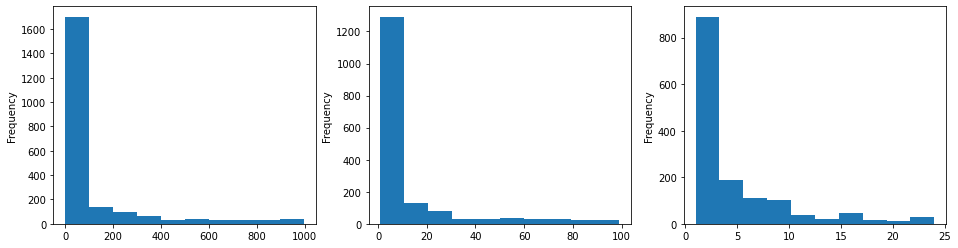

In [46]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16, 4]
plt.subplot(1,3,1)
raid_df_clean.num_raiders.plot.hist()
plt.subplot(1,3,2)
raid_df_clean[raid_df_clean.num_raiders <100].num_raiders.plot.hist()
plt.subplot(1,3,3)
raid_df_clean[raid_df_clean.num_raiders <25].num_raiders.plot.hist()

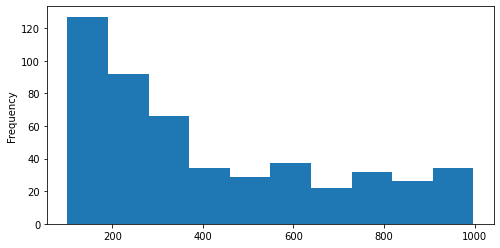

In [49]:
plt.rcParams['figure.figsize'] = [8, 4]
raid_df_clean[raid_df_clean.num_raiders >100].num_raiders.plot.hist()

In [24]:
# This saves to google drive directly
raid_df_clean.to_csv('raid_df.csv')

## Towards identification

If incoming raids leads to exogenous change in viewership and chat intensity?

First let's take a look at the video level numbers. 
- Find the raids that happened during the video time range. 
- Then aggregate, Number of raids, total number of viewers raided. 

In [25]:
features_vid_df_lag['created_at'] = pd.to_datetime(features_vid_df_lag['created_at']).dt.tz_localize(None)
features_vid_df_lag['ended_at'] = features_vid_df_lag['created_at'] + pd.to_timedelta(features_vid_df_lag['duration_min'], unit='m') 

In [26]:
#features_vid_df_lag.user_name
#raid_df.Whom.unique()

In [27]:
#for i in range(2):
for i in range(len(features_vid_df_lag.user_name.unique())):
  streamer = features_vid_df_lag.user_name.unique()[i]
  temp_vid_table = features_vid_df_lag[features_vid_df_lag.user_name == streamer][['user_name','video_id','created_at','ended_at']]
  temp_raid_table = raid_df_clean[raid_df_clean['user_name'] == streamer]
  temp_raid_table = temp_raid_table.loc[(temp_raid_table['timestamp'] >= temp_vid_table['created_at'].min()) & (temp_raid_table['timestamp']<= temp_vid_table['created_at'].max())]
  print(temp_vid_table['user_name'].unique(),temp_raid_table.user_name.unique())
  
  temp = pd.merge(temp_vid_table, temp_raid_table,  how='left', left_on=['user_name'], right_on = ['user_name'])
  temp = temp[(temp['timestamp'] >= temp['created_at']) & (temp['timestamp'] <= temp['ended_at'])]

  if i ==0:
    vid_df_wraid = temp
    print(len(temp),len(vid_df_wraid))
  else: 
    vid_df_wraid = vid_df_wraid.append(temp)
    print(len(temp),len(vid_df_wraid))

vid_df_wraid = vid_df_wraid.reset_index(drop=True)

['zackrawrr'] ['zackrawrr']
4 4
['Methodz'] ['Methodz']
2 6
['SypherPK'] ['SypherPK']
0 6
['iiTzTimmy'] ['iiTzTimmy']
0 6
['AkzOnTop'] []
0 6
['VNCEOfficial'] ['VNCEOfficial']
2 8
['Rainbow6'] ['Rainbow6']
2 10
['moistcr1tikal'] ['moistcr1tikal']
11 21
['General_Mars'] []
0 21
['Murda10k'] []
0 21
['PatProzyy'] ['PatProzyy']
0 21
['prxd4v41'] ['prxd4v41']
12 33


In [29]:
vid_df_wraid.to_csv('vid_df_wraid.csv')

In [28]:
vid_df_wraid.head()

,user_name,video_id,created_at,ended_at,Channel,Raided/Hosted,timestamp,num_raiders
0,zackrawrr,1610656682,2022-10-06 05:28:07,2022-10-06 09:26:50.999999980,ArcAngL,raided,2022-10-06 09:01:00,4.0
1,zackrawrr,1610656682,2022-10-06 05:28:07,2022-10-06 09:26:50.999999980,MeatCuddle,raided,2022-10-06 08:00:00,5.0
2,zackrawrr,1610656682,2022-10-06 05:28:07,2022-10-06 09:26:50.999999980,EternalNess,raided,2022-10-06 07:32:00,1.0
3,zackrawrr,1610656682,2022-10-06 05:28:07,2022-10-06 09:26:50.999999980,emialbasta,raided,2022-10-06 07:29:00,4.0
4,Methodz,1605572910,2022-09-30 18:40:36,2022-09-30 22:17:30.000000000,Hitchariide,raided,2022-09-30 21:25:00,534.0


In [55]:
raid_sum_df = vid_df_wraid.groupby('video_id')['num_raiders'].sum().reset_index()
features_vid_df_lag_raid = pd.merge(features_vid_df_lag, raid_sum_df,  how='left', left_on=['video_id'], right_on = ['video_id'])

In [56]:
features_vid_df_lag_raid['num_raiders'].fillna(0,inplace=True)
features_vid_df_lag_raid['num_raiders'] = features_vid_df_lag_raid['num_raiders']

In [57]:
raid_sum_df

,video_id,num_raiders
0,1591613035,10.0
1,1592319276,19.0
2,1595352118,6.0
3,1598015150,115.0
4,1605572910,1434.0
5,1606861627,5.0
6,1606964718,844.0
7,1607634101,5.0
8,1610256098,27.0
9,1610306079,1.0


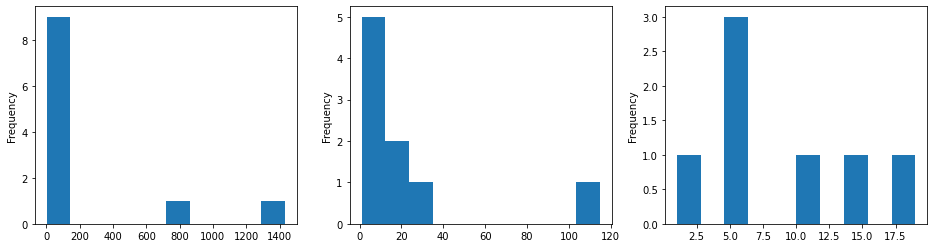

In [58]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16, 4]
plt.subplot(1,3,1)
raid_sum_df.num_raiders.plot.hist()
plt.subplot(1,3,2)
raid_sum_df[raid_sum_df.num_raiders <200].num_raiders.plot.hist()
plt.subplot(1,3,3)
raid_sum_df[raid_sum_df.num_raiders <20].num_raiders.plot.hist()

In [59]:
# print(len(features_vid_df_lag),len(features_vid_df_lag_raid))

In [60]:
features_vid_df_lag_raid.isnull().sum()

user_id                            0
video_id                           0
video_url                          0
num_messages                       0
message_len                        0
video_id.1                         0
num_messages_per_min               0
user_id.1                          0
user_name                          0
duration_min                       0
created_at                         0
title                              0
view_count                         0
broadcaster_type                   2
broadcast_description              0
broadcaster_created_at             0
avg_messages_per_min               0
sentiment_positive_percent         0
sentiment_score                    0
video_url_lag                     12
num_messages_lag                  12
message_len_lag                   12
video_id_lag                      12
num_messages_per_min_lag          12
user_id_lag                       12
user_name_lag                     12
duration_min_lag                  12
c

In [61]:
features_vid_df_lag_raid.to_csv('features_vid_df_lag_raid.csv')

In [62]:
features_vid_df_lag_raid[['num_raiders','num_messages_per_min','num_messages','message_len','duration_min']].corr()

,num_raiders,num_messages_per_min,num_messages,message_len,duration_min
num_raiders,1.000000,0.233323,0.303520,-0.035968,0.177713
num_messages_per_min,0.233323,1.000000,0.801703,-0.232958,-0.022404
num_messages,0.303520,0.801703,1.000000,-0.129868,0.409100
message_len,-0.035968,-0.232958,-0.129868,1.000000,0.049782
duration_min,0.177713,-0.022404,0.409100,0.049782,1.000000


In [63]:
#temp = features_vid_df_lag_raid.drop(features_vid_df_lag_raid['num_raiders'].idxmax())
temp = features_vid_df_lag_raid[features_vid_df_lag_raid.num_raiders < features_vid_df_lag_raid.num_raiders.quantile(.99)]
temp[['num_raiders','view_count','num_messages_per_min','num_messages','message_len','duration_min']].corr()

,num_raiders,view_count,num_messages_per_min,num_messages,message_len,duration_min
num_raiders,1.000000,0.222943,0.434658,0.415060,-0.047835,0.089246
view_count,0.222943,1.000000,0.573630,0.767048,-0.091009,0.377927
num_messages_per_min,0.434658,0.573630,1.000000,0.805091,-0.232835,-0.024558
num_messages,0.415060,0.767048,0.805091,1.000000,-0.129196,0.399648
message_len,-0.047835,-0.091009,-0.232835,-0.129196,1.000000,0.052470
duration_min,0.089246,0.377927,-0.024558,0.399648,0.052470,1.000000


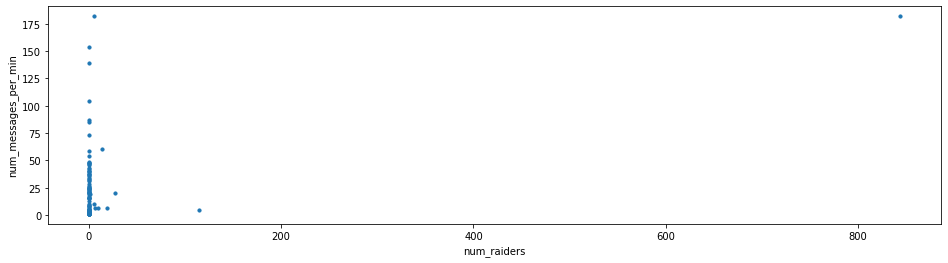

In [64]:
temp.plot.scatter(x = 'num_raiders', y = 'num_messages_per_min', s = 10);

In [65]:
#temp = features_vid_df_lag_raid.drop(features_vid_df_lag_raid['num_raiders'].idxmax())
temp = features_vid_df_lag_raid[features_vid_df_lag_raid.num_raiders < features_vid_df_lag_raid.num_raiders.quantile(.95)]
temp = temp[temp['num_raiders'] != 0 ]
temp[['num_raiders','view_count','num_messages_per_min','num_messages','message_len','duration_min']].corr()

,num_raiders,view_count,num_messages_per_min,num_messages,message_len,duration_min
num_raiders,1.000000,0.568126,-0.011940,0.307020,-0.840062,0.825538
view_count,0.568126,1.000000,0.762578,0.945996,-0.611010,0.207940
num_messages_per_min,-0.011940,0.762578,1.000000,0.925392,-0.221251,-0.299998
num_messages,0.307020,0.945996,0.925392,1.000000,-0.412072,-0.020504
message_len,-0.840062,-0.611010,-0.221251,-0.412072,1.000000,-0.547965
duration_min,0.825538,0.207940,-0.299998,-0.020504,-0.547965,1.000000


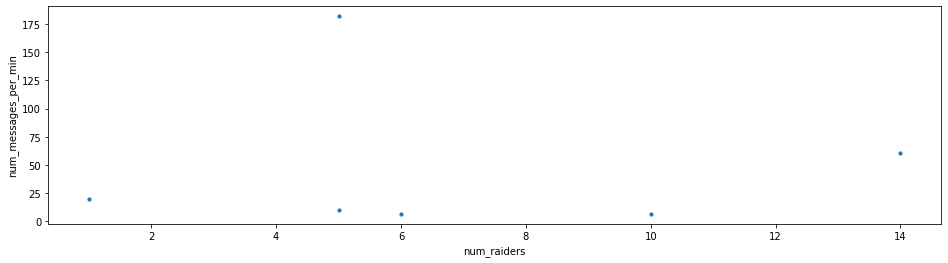

In [66]:
temp.plot.scatter(x = 'num_raiders', y = 'num_messages_per_min', s = 10);

In [ ]:
#!pip install linearmodels
!pip install stargazer

In [71]:
# econometrics in python: https://medium.com/@vince.shields913/econometrics-with-python-pt-4-20b7842f01df
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

est_df = features_vid_df_lag_raid

fml = 'num_messages_per_min ~ num_raiders '
reg1 = smf.ols(formula= fml, data=est_df).fit(cov_type = 'HC3')

fml = 'num_messages_per_min ~ num_raiders + np.log(view_count+1)'
reg2 = smf.ols(formula= fml, data=est_df).fit(cov_type = 'HC3')

fml = 'num_messages_per_min ~ num_raiders + np.log(view_count+1) + sentiment_positive_percent +sentiment_score'
reg3 = smf.ols(formula= fml, data=est_df).fit(cov_type = 'HC3')

stargazer = Stargazer([reg1, reg2,reg3])
HTML(stargazer.render_html())


## Ignore code down below

In [ ]:
raid_df['Date'][4]

'Oct 28, 2022 at 19:54'

In [ ]:
# makes a GET request to a URL and returns the text from that page.
def get_page(url):
    return requests.get(url).content

In [ ]:
page = get_page('https://streamscharts.com/tools/raid-finder/vnceofficial')
page

In [ ]:
soup = BeautifulSoup(page, 'html.parser') # parses the document using a HTML parser

In [ ]:
lists = soup.find_all('th')

In [ ]:
lists

In [ ]:
import re

In [ ]:
url = "raid_VNCEOOfficial.html"
page = open(url)

In [ ]:
page.text()

AttributeError: ignored

In [ ]:
soup = BeautifulSoup(page,'html.parser')

In [ ]:
print(table)

In [ ]:
header = table.find_all('th')

AttributeError: ignored

In [ ]:
print(table)

None


In [ ]:
soup